In [ ]:
# Bibliotheken importieren
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV-Datei laden
df = pd.read_csv("../data/listings.csv")

# Erste 5 Zeilen anzeigen
df.head()



## 1. Überblick über den Datensatz 🧐

Bevor wir in die Analyse der Airbnb-Daten einsteigen, schauen wir uns die Struktur und Qualität der Daten an:
- Wie viele Zeilen und Spalten enthält der Datensatz?
- Welche Spalten sind enthalten?
- Welche Datentypen haben die Spalten?
- Gibt es fehlende Werte?

Dieser Schritt ist wichtig, um die Datenbasis zu verstehen und mögliche Probleme (z. B. fehlende Werte) frühzeitig zu erkennen.


In [5]:
# Größe des Datensatzes (Anzahl Zeilen und Spalten)
df.shape

# Spaltennamen anzeigen
df.columns

# Datentypen und Speicherverbrauch überprüfen
df.info()

# Anzahl fehlender Werte pro Spalte anzeigen
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7863 entries, 0 to 7862
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7863 non-null   int64  
 1   listing_url                                   7863 non-null   object 
 2   scrape_id                                     7863 non-null   int64  
 3   last_scraped                                  7863 non-null   object 
 4   source                                        7863 non-null   object 
 5   name                                          7863 non-null   object 
 6   description                                   7742 non-null   object 
 7   neighborhood_overview                         4980 non-null   object 
 8   picture_url                                   7863 non-null   object 
 9   host_id                                       7863 non-null   i

neighbourhood_group_cleansed    7863
calendar_updated                7863
host_about                      2884
neighborhood_overview           2883
neighbourhood                   2883
                                ... 
minimum_nights                     0
maximum_nights                     0
host_has_profile_pic               0
availability_30                    0
id                                 0
Length: 75, dtype: int64

## 2. Auswahl relevanter Spalten 🏠

Der vollständige Airbnb-Datensatz enthält viele Spalten, die für die Preis- und Standortanalyse nicht notwendig sind.
Wir konzentrieren uns auf die wichtigsten Spalten, die uns interessante Einblicke liefern:

- `price`: Preis pro Nacht
- `room_type`: Art der Unterkunft (z. B. Privatzimmer, Wohnung)
- `neighbourhood_cleansed`: Stadtteil, in dem die Unterkunft liegt
- `minimum_nights`: Mindestanzahl an Nächten pro Buchung
- `number_of_reviews`: Anzahl der Bewertungen
- `reviews_per_month`: Durchschnittliche Anzahl an Bewertungen pro Monat
- `availability_365`: Anzahl der Tage, an denen die Unterkunft im Jahr verfügbar ist
- `review_scores_rating`: Bewertung der Unterkunft


In [6]:
# Auswahl der relevanten Spalten für die Analyse
df_filtered = df[['price', 'room_type', 'neighbourhood_cleansed', 'minimum_nights',
                  'number_of_reviews', 'reviews_per_month', 'availability_365', 'review_scores_rating']]

# Ersten Blick auf die gefilterten Daten werfen
df_filtered.head()


,price,room_type,neighbourhood_cleansed,minimum_nights,number_of_reviews,reviews_per_month,availability_365,review_scores_rating
0,$140.00,Entire home/apt,Nob Hill,30,4,0.19,41,4.5
1,$360.00,Entire home/apt,Western Addition,30,0,NaN,277,NaN
2,NaN,Private room,Noe Valley,30,1,0.01,0,5.0
3,$48.00,Private room,Outer Mission,30,0,NaN,364,NaN
4,NaN,Entire home/apt,Outer Mission,30,0,NaN,0,NaN


## 3. Bereinigung der Preis-Spalte 💸 (final)

In der Preis-Spalte (`price`) sind die Werte häufig als String gespeichert, z. B. `$150.00`.  
Wir entfernen das Dollarzeichen und wandeln die Werte in Zahlen (`float`) um.  
Dabei nutzen wir `.loc[]`, um die sogenannte `SettingWithCopyWarning` zu vermeiden.


In [9]:
# Preis-Spalte bereinigen: $-Zeichen entfernen und in Float umwandeln
# SettingWithCopyWarning wird durch .loc[] umgangen
df_filtered.loc[:, 'price'] = df_filtered['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Überprüfen, ob die Umwandlung funktioniert hat
df_filtered['price'].head()


0    140.0
1    360.0
2      NaN
3     48.0
4      NaN
Name: price, dtype: float64

## 4. Visualisierung: Preisverteilung 🏠💸

Um einen ersten Eindruck über die Preisstruktur der Airbnb-Unterkünfte in der Stadt zu bekommen,  
plotten wir die Verteilung der Preise in einem Histogramm.

Da es häufig **Ausreißer (z. B. Luxusunterkünfte)** mit sehr hohen Preisen gibt,  
begrenzen wir die Preisskala auf **maximal 500 € pro Nacht** – so wird die Grafik aussagekräftiger.


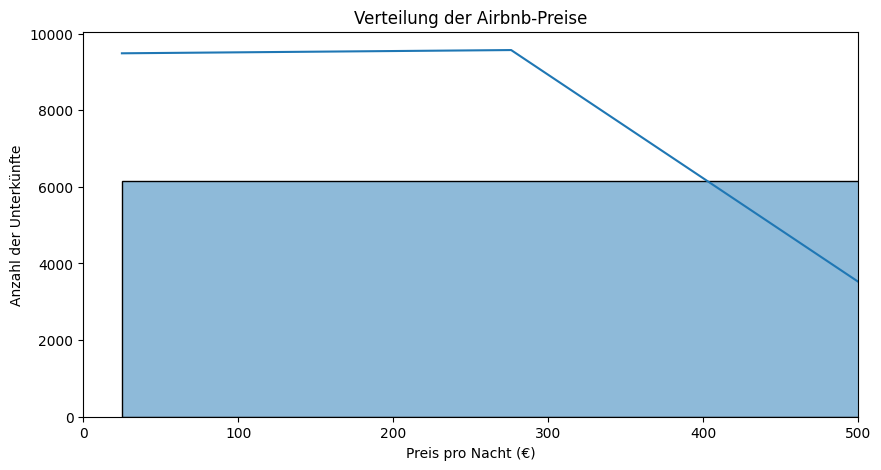

In [10]:
# Visualisierung der Preisverteilung mit Histogramm

# Grafikgröße einstellen
plt.figure(figsize=(10, 5))

# Histogramm mit Seaborn erstellen
sns.histplot(df_filtered['price'], bins=50, kde=True)

# Preisbereich begrenzen (z. B. max. 500 € pro Nacht)
plt.xlim(0, 500)

# Achsenbeschriftung und Titel hinzufügen
plt.xlabel("Preis pro Nacht (€)")
plt.ylabel("Anzahl der Unterkünfte")
plt.title("Verteilung der Airbnb-Preise")

# Grafik anzeigen
plt.show()


## 5. Preisverteilung nach Unterkunftstyp 🏠🏨

Um besser zu verstehen, wie sich die Preise je nach Unterkunftstyp unterscheiden,  
schauen wir uns die Verteilung der Preise für die verschiedenen `room_type`-Kategorien an.

Besonders interessant ist die Frage:  
Sind **ganze Wohnungen teurer** als **Privatzimmer** oder **Gemeinschaftszimmer**?


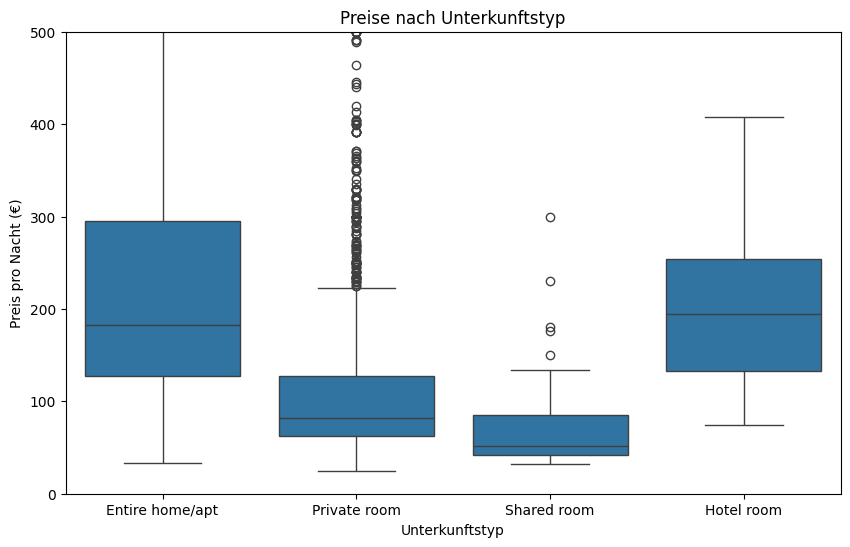

In [11]:
# Visualisierung: Preise nach Unterkunftstyp (room_type)

# Grafikgröße einstellen
plt.figure(figsize=(10, 6))

# Boxplot erstellen – zeigt Verteilung und Ausreißer
sns.boxplot(x='room_type', y='price', data=df_filtered)

# Preisbereich begrenzen (optional, z. B. max. 500 €)
plt.ylim(0, 500)

# Achsenbeschriftung und Titel
plt.xlabel("Unterkunftstyp")
plt.ylabel("Preis pro Nacht (€)")
plt.title("Preise nach Unterkunftstyp")

# Grafik anzeigen
plt.show()


## 6. Durchschnittspreise nach Stadtteil 🏙️

Ein Blick auf die **durchschnittlichen Preise pro Stadtteil** zeigt,  
welche Viertel teurer und welche günstiger sind.  
Das ist besonders spannend für Nutzer, die in einer bestimmten Gegend wohnen oder reisen wollen.


In [12]:
# Gruppieren nach Stadtteil und Durchschnittspreis berechnen
preis_nach_stadtteil = df_filtered.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Ausgabe der Top 10 teuersten Stadtteile
preis_nach_stadtteil.head(10)


neighbourhood_cleansed
Castro/Upper Market    514.276860
Russian Hill           404.708609
Presidio               380.894737
Pacific Heights        363.458824
Western Addition       345.944844
Financial District     342.354167
Inner Richmond         340.322404
Marina                 287.227723
Presidio Heights       278.181818
North Beach            270.345070
Name: price, dtype: float64

## 7. Visualisierung: Top 10 teuerste Stadtteile 📊


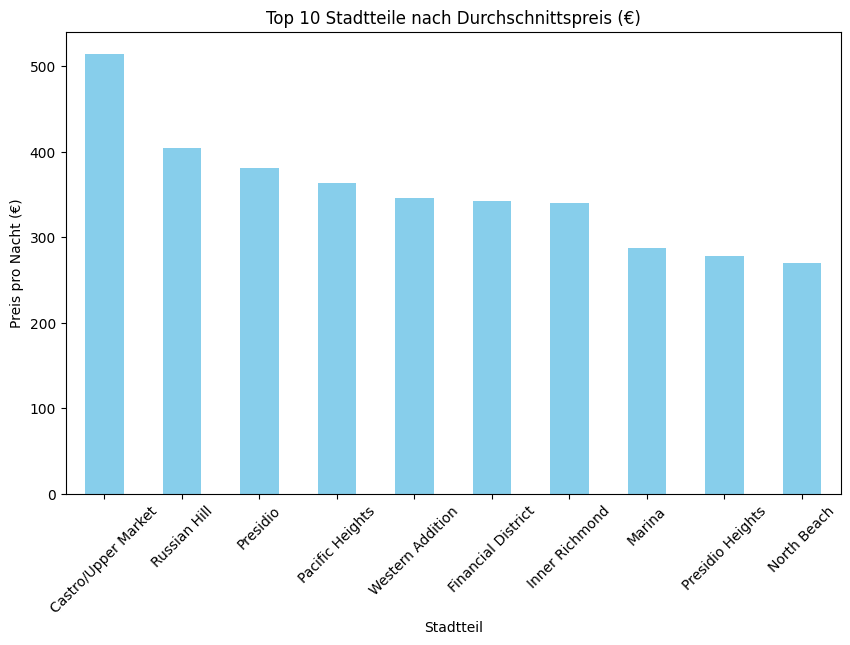

In [13]:
# Visualisierung: Top 10 Stadtteile nach Preis
plt.figure(figsize=(10, 6))
preis_nach_stadtteil.head(10).plot(kind='bar', color='skyblue')

plt.title("Top 10 Stadtteile nach Durchschnittspreis (€)")
plt.xlabel("Stadtteil")
plt.ylabel("Preis pro Nacht (€)")

plt.xticks(rotation=45)  # Stadtteile schräg schreiben für bessere Lesbarkeit
plt.show()


## 8. Visualisierung: Top 10 günstigste Stadtteile 🏠

Neben den teuersten Stadtteilen ist es für Reisende oft genauso spannend zu sehen,  
**wo die günstigsten Airbnb-Unterkünfte** zu finden sind.


In [14]:
# Ausgabe der 10 günstigsten Stadtteile
preis_nach_stadtteil.tail(10)


neighbourhood_cleansed
Outer Richmond       172.006098
Outer Mission        160.717742
Parkside             143.210084
Outer Sunset         133.731788
Visitacion Valley    130.434783
Ocean View           129.735849
Bayview              123.277311
Lakeshore            120.925926
Excelsior            110.061224
Crocker Amazon       100.586957
Name: price, dtype: float64

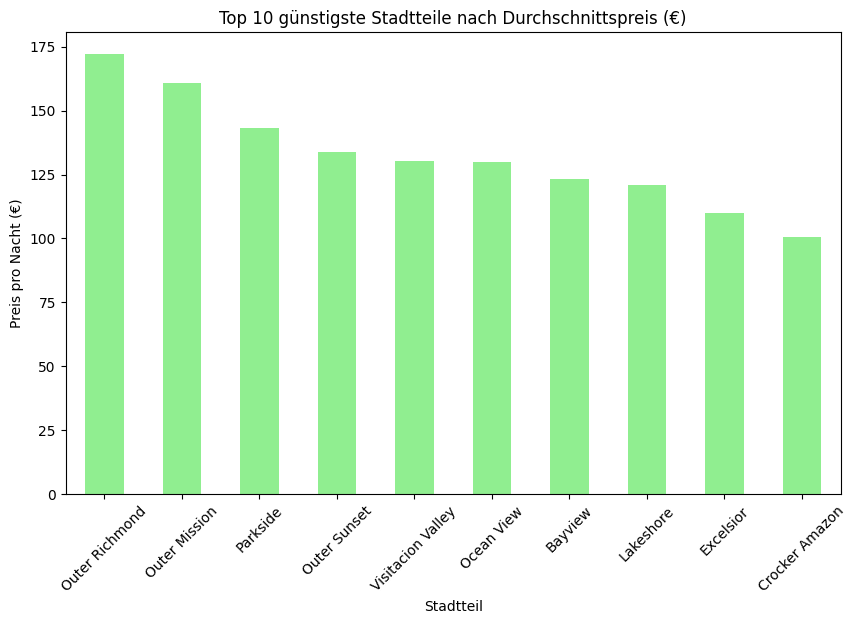

In [15]:
# Visualisierung: Günstigste Stadtteile
plt.figure(figsize=(10, 6))
preis_nach_stadtteil.tail(10).plot(kind='bar', color='lightgreen')

plt.title("Top 10 günstigste Stadtteile nach Durchschnittspreis (€)")
plt.xlabel("Stadtteil")
plt.ylabel("Preis pro Nacht (€)")

plt.xticks(rotation=45)
plt.show()


In [16]:
# Teuerste Stadtteile speichern
plt.figure(figsize=(10, 6))
preis_nach_stadtteil.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Stadtteile nach Durchschnittspreis (€)")
plt.xlabel("Stadtteil")
plt.ylabel("Preis pro Nacht (€)")
plt.xticks(rotation=45)
plt.savefig('../visuals/top_10_teuerste_stadtteile.png')
plt.close()

# Günstigste Stadtteile speichern
plt.figure(figsize=(10, 6))
preis_nach_stadtteil.tail(10).plot(kind='bar', color='lightgreen')
plt.title("Top 10 günstigste Stadtteile nach Durchschnittspreis (€)")
plt.xlabel("Stadtteil")
plt.ylabel("Preis pro Nacht (€)")
plt.xticks(rotation=45)
plt.savefig('../visuals/top_10_guenstigste_stadtteile.png')
plt.close()
